## HW1 手工搭建三层网络

### 模型方法的构建

* 首先，我们需要导入一些必要的库，包括 NumPy 用于数值计算和数据处理。训练集和测试集已经分好，并且标签是整数

In [13]:
import numpy as np
import random
from utils import mnist_reader
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from PIL import Image

random.seed(20010326)
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
#对Y做one-hot编码
y_train,y_test = np.eye(10)[y_train],np.eye(10)[y_test]
print(np.shape(X_test),np.shape(y_test))# 10000条test数据，每个是28x28的灰度图,label值为0-9的整数
len(y_test)
print(np.shape(X_train))


(10000, 784) (10000, 10)
(60000, 784)


* 定义三层神经网络的模型

In [14]:
class NeuralNetwork:# 三层网络，含有2隐藏层。
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation1='relu', activation2='sigmoid',learning_rate=1e-4, decay_rate=0.2):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.activation1 = activation1
        self.activation2 = activation2
        self.decay_rate = decay_rate
        self.iterations = 0
        self.learning_rate = learning_rate

        
        # 初始化权重和偏置
        self.weights1 = np.random.randn(self.input_size, self.hidden_size1)
        self.bias1 = np.zeros((1, self.hidden_size1))
        self.weights2 = np.random.randn(self.hidden_size1, self.hidden_size2)
        self.bias2 = np.zeros((1, self.hidden_size2))
        self.weights3 = np.random.randn(self.hidden_size2, self.output_size)
        self.bias3 = np.zeros((1, self.output_size))

    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def relu_derivative(self, x):
        return (x > 0).astype(int)
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def adjust_learning_rate(self):
        # 根据衰减率更新学习率
        self.learning_rate /=(1 + self.decay_rate * self.iterations)

    def forward(self, X):
        # 前向传播
        self.z1 = np.dot(X, self.weights1) + self.bias1
        if self.activation1 == 'relu':
            self.a1 = self.relu(self.z1)
        elif self.activation1 == 'sigmoid':
            self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.activation2 == 'relu':
            self.a2 = self.relu(self.z2)
        elif self.activation2 == 'sigmoid':
            self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.weights3) + self.bias3
        # self.z3 = np.array(self.z3,dtype=np.float64)
        self.output = np.exp(self.z3) / np.sum(np.exp(self.z3), axis=1, keepdims=True) # softmax输出
    
        return self.output
    
    def backward(self, X, y):
        # 反向传播
        m = X.shape[0]
        
        # 计算输出层的误差
        dZ3 = self.output - y #softmax+entropyloss可确定损失的微分
        
        # 更新输出层的权重和偏置
        dW3 = np.dot(self.a2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        
        # 计算第二个隐藏层的误差
        if self.activation2 == 'relu':
            dZ2 = np.dot(dZ3, self.weights3.T) * self.relu_derivative(self.z2)
        elif self.activation2 == 'sigmoid':
            dZ2 = np.dot(dZ3, self.weights3.T) * self.sigmoid_derivative(self.z2)
        
        # 更新第二个隐藏层的权重和偏置
        dW2 = np.dot(self.a1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # 计算第一个隐藏层的误差
        if self.activation1 == 'relu':
            dZ1 = np.dot(dZ2, self.weights2.T) * self.relu_derivative(self.z1)
        elif self.activation1 == 'sigmoid':
            dZ1 = np.dot(dZ2, self.weights2.T) * self.sigmoid_derivative(self.z1)
        
        # 更新第一个隐藏层的权重和偏置
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        # 使用梯度下降更新权重和偏置
        self.weights3 -= self.learning_rate * dW3
        self.bias3 -= self.learning_rate * db3
        self.weights2 -= self.learning_rate * dW2
        self.bias2 -= self.learning_rate * db2
        self.weights1 -= self.learning_rate * dW1
        self.bias1 -= self.learning_rate * db1


* 训练部分。我们需要定义损失函数、优化器（这里使用 SGD）、学习率下降、交叉熵损失和 L2 正则化，并能根据验证集指标自动保存最优的模型权重

In [15]:
def cross_entropy_loss(predictions, targets):
    # 计算交叉熵损失
    loss = -np.sum(targets* np.log(predictions + 1e-12)) / len(targets)
    return loss

def visualize(W,file_path):
    array = np.array(W, dtype=np.uint8)
    
    # 创建PIL Image对象
    image = Image.fromarray(array, mode='L')  # 'L'表示灰度图像
    
    # 保存图像
    image.save(file_path)
    
def train(X_train, y_train,X_val, y_val, model, num_epochs, batch_size,regularization=0.005):
    best_val_loss = float('inf')
    best_weights = None
    loss_log = []
    # Creates writer1 object.
    writer1 = SummaryWriter('log/exp_base/')
    for epoch in range(num_epochs):
        model.iterations +=1
        # 每个 epoch 进行一次随机梯度下降，随机选取一个batch计算梯度
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        
        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            # 前向传播
            predictions = model.forward(X_batch)
            # 计算损失
            loss = cross_entropy_loss(predictions, y_batch)
            # 加入L2正则化项
            regularization_loss = 0.5 * (np.sum(np.square(model.weights1)) + np.sum(np.square(model.weights2)))
            loss += regularization * regularization_loss
            
            # 反向传播
            model.backward(X_batch, y_batch)
            
        # 验证集上计算损失
        val_predictions = model.forward(X_val)
        val_loss = cross_entropy_loss(val_predictions, y_val)
        loss_log.append(val_loss)
        
        # 更新lr并保存此时的网络参数
        if model.iterations %100==0:
            visualize(model.weights1,f'./log/w1_{model.iterations}.png')
            visualize(model.weights2,f'./log/w2_{model.iterations}.png')
            visualize(model.weights3,f'./log/w3_{model.iterations}.png')
            writer1.add_histogram('w1',model.weights1,global_step=model.iterations)
            writer1.add_histogram('b1',model.bias1,global_step=model.iterations)
            writer1.add_histogram('w2',model.weights2,global_step=model.iterations)
            writer1.add_histogram('b2',model.bias2,global_step=model.iterations)
            writer1.add_histogram('w3',model.weights3,global_step=model.iterations)
            writer1.add_histogram('b3',model.bias3,global_step=model.iterations)

            model.adjust_learning_rate()
            print(f"当前epoch:{model.iterations};当前lr:{model.learning_rate}")
        # 如果当前模型在验证集上的损失更低，则保存模型权重
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = {
                'weights1': model.weights1,
                'bias1': model.bias1,
                'weights2': model.weights2,
                'bias2': model.bias2
            }
            print("Epoch {}, Validation Loss: {:.4f}".format(epoch+1, val_loss))
    plt.plot(loss_log)
    return best_weights


* 加载参数和测试

In [16]:
def test(model,X_test, y_test, best_weights):
    # 导入最优的模型权重
    model.weights1 = best_weights['weights1']
    model.bias1 = best_weights['bias1']
    model.weights2 = best_weights['weights2']
    model.bias2 = best_weights['bias2']
    
    # 在测试集上进行预测
    predictions = model.forward(X_test)
    y_pred = [np.argmax(pred) for pred in predictions]
    y_test_origin = [np.argmax(y) for y in y_test]
    test_acc = accuracy_score(y_test_origin,y_pred)
    print("Test Accuracy: {:.2%}".format(test_acc))

def accuracy_score(gt,pred):
    assert len(gt)==len(pred),"数量不一致"
    n = len(gt)
    return sum([1 if gt[i]==pred[i] else 0 for i in range(n)])/n


### 模型参数选择和训练

C:\Users\69034\AppData\Local\Temp\ipykernel_12924\1475594127.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1, Validation Loss: 2.4833
Epoch 2, Validation Loss: 2.2488
Epoch 3, Validation Loss: 1.9735
Epoch 4, Validation Loss: 1.9007
Epoch 5, Validation Loss: 1.7452
Epoch 6, Validation Loss: 1.6828
Epoch 7, Validation Loss: 1.5915
Epoch 9, Validation Loss: 1.5535
Epoch 10, Validation Loss: 1.5073
Epoch 11, Validation Loss: 1.4730
Epoch 13, Validation Loss: 1.3575
Epoch 14, Validation Loss: 1.3476
Epoch 15, Validation Loss: 1.3193
Epoch 19, Validation Loss: 1.3015
Epoch 21, Validation Loss: 1.2494
Epoch 22, Validation Loss: 1.2205
Epoch 23, Validation Loss: 1.2109
Epoch 24, Validation Loss: 1.1861
Epoch 25, Validation Loss: 1.1724
Epoch 28, Validation Loss: 1.1533
Epoch 29, Validation Loss: 1.1367
Epoch 31, Validation Loss: 1.1134
Epoch 34, Validation Loss: 1.0689
Epoch 36, Validation Loss: 1.0505
Epoch 37, Validation Loss: 1.0452
Epoch 38, Validation Loss: 1.0319
Epoch 39, Validation Loss: 1.0301
Epoch 40, Validation Loss: 1.0257
Epoch 42, Validation Loss: 1.0148
Epoch 43, Validation L

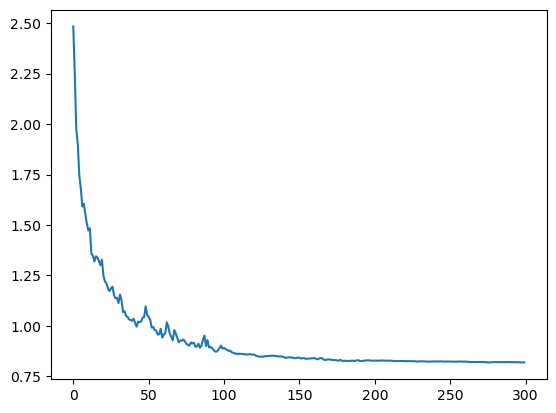

In [17]:
## main:超参数选择

# model= NeuralNetwork(input_size=784,hidden_size1=128,hidden_size2=32,output_size=10,learning_rate=1e-3,decay_rate=0.05)
model= NeuralNetwork(input_size=784,hidden_size1=64,hidden_size2=32,output_size=10,learning_rate=1e-3,decay_rate=0.05)
# model= NeuralNetwork(input_size=784,hidden_size1=128,hidden_size2=16,output_size=10,learning_rate=1e-3,decay_rate=0.05)
# model= NeuralNetwork(input_size=784,hidden_size1=64,hidden_size2=16,output_size=10,learning_rate=1e-3,decay_rate=0.05)
######
# model= NeuralNetwork(input_size=784,hidden_size1=64,hidden_size2=32,output_size=10,learning_rate=5e-3)
# model= NeuralNetwork(input_size=784,hidden_size1=64,hidden_size2=32,output_size=10,learning_rate=1e-3,decay_rate=0.1)
# model= NeuralNetwork(input_size=784,hidden_size1=64,hidden_size2=32,output_size=10,learning_rate=1e-3,decay_rate=0.2)

save_weights = train(X_train,y_train,X_test,y_test,model,num_epochs=300,batch_size=32)
# save_weights = train(X_train,y_train,X_test,y_test,model,num_epochs=300,batch_size=32,regularization=0.01)
# save_weights = train(X_train,y_train,X_test,y_test,model,num_epochs=300,batch_size=32,regularization=0.001)
# save_weights = train(X_train,y_train,X_test,y_test,model,num_epochs=300,batch_size=16)
test(model,X_test,y_test,best_weights=save_weights)